In [359]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import tokenize
import io

In [319]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Embedding, Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D, LSTM, SimpleRNN, SpatialDropout1D, Attention
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [174]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [175]:
df_code_py = pd.read_parquet('df_code_py.gzip')

In [176]:
df_code_py.head()

,academic_year_1,task,user,date,academic_year_0,upload,module,correct,hour_submitted,tokens,token_count,line_count,token_code_only,token_per_line
0,2017,add.py,b9e7e608-6036-4d44-8770-a7036176b53c,2016-09-19 14:11:41,2016,#!/usr/bin/env python\n\na = int(raw_input())\...,ca277,True,14,"[{'end': [1, 21], 'line': '#!/usr/bin/env pyth...",30,4,"[\n, a, =, int, (, raw_input, (, ), ), \n, b, ...",7.5
1,2017,concat-lines.py,b9e7e608-6036-4d44-8770-a7036176b53c,2016-09-19 14:17:33,2016,#!/usr/bin/env python\n\na = str(raw_input())\...,ca277,True,14,"[{'end': [1, 21], 'line': '#!/usr/bin/env pyth...",30,4,"[\n, a, =, str, (, raw_input, (, ), ), \n, b, ...",7.5
2,2017,goodbye.py,b9e7e608-6036-4d44-8770-a7036176b53c,2016-09-19 10:15:59,2016,"#!/usr/bin/env python\n\nprint ""Goodbye""\n",ca277,True,10,"[{'end': [1, 21], 'line': '#!/usr/bin/env pyth...",7,2,"[\n, print, ""Goodbye"", \n]",3.5
3,2017,less-than.py,b9e7e608-6036-4d44-8770-a7036176b53c,2016-09-19 14:14:22,2016,#!/usr/bin/env python\n\na = int(raw_input())\...,ca277,True,14,"[{'end': [1, 21], 'line': '#!/usr/bin/env pyth...",30,4,"[\n, a, =, int, (, raw_input, (, ), ), \n, b, ...",7.5
4,2017,longest-line.py,b9e7e608-6036-4d44-8770-a7036176b53c,2016-09-19 14:51:28,2016,#!usr/bin/evn python\n\na = raw_input()\nb = r...,ca277,True,14,"[{'end': [1, 20], 'line': '#!usr/bin/evn pytho...",42,7,"[\n, a, =, raw_input, (, ), \n, b, =, raw_inpu...",6.0


In [409]:
df_code_py.shape

(378455, 14)

In [410]:
df_code_py_exp = df_code_py
#df_code_py_exp = df_code_py[df_code_py["task"]=="ex3-first-long-word.py"]

In [411]:
df_code_py_exp.iloc[0].tokens

array([{'end': array([ 1, 21], dtype=int64), 'line': '#!/usr/bin/env python\n', 'start': array([1, 0], dtype=int64), 'string': '#!/usr/bin/env python', 'type': 61},
       {'end': array([ 1, 22], dtype=int64), 'line': '#!/usr/bin/env python\n', 'start': array([ 1, 21], dtype=int64), 'string': '\n', 'type': 62},
       {'end': array([2, 1], dtype=int64), 'line': '\n', 'start': array([2, 0], dtype=int64), 'string': '\n', 'type': 62},
       {'end': array([3, 1], dtype=int64), 'line': 'a = int(raw_input())\n', 'start': array([3, 0], dtype=int64), 'string': 'a', 'type': 1},
       {'end': array([3, 3], dtype=int64), 'line': 'a = int(raw_input())\n', 'start': array([3, 2], dtype=int64), 'string': '=', 'type': 54},
       {'end': array([3, 7], dtype=int64), 'line': 'a = int(raw_input())\n', 'start': array([3, 4], dtype=int64), 'string': 'int', 'type': 1},
       {'end': array([3, 8], dtype=int64), 'line': 'a = int(raw_input())\n', 'start': array([3, 7], dtype=int64), 'string': '(', 'type': 5

In [412]:
MAX_NUM_WORDS = 100
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 50

In [516]:
def tokenizer_custom(t_list):    
    
    if isinstance(t_list, np.ndarray):
        #print(t_list)
        return t_list
    else:
        temp_tokens = None
        t_dict = None
        t_code_only = []
        with io.StringIO(t_list) as f:
            line = f.readline
            temp_tokens = tokenize.generate_tokens(line)
            try:
                for token in temp_tokens:
                    t_dict = token._asdict()
                    #print(t_dict)
                    #print(t_dict["string"])
                    if t_dict["line"] == "\n" or t_dict["type"] == 0:
                        pass
                    elif t_dict["type"] != 61:
                        # tokenize only the code not comments
                        t_code_only.append(t_dict["string"])
            except:
                pass
        return np.array(t_code_only)

In [517]:
tokenizer = Tokenizer(num_words = MAX_NUM_WORDS, filters=None, lower=True, analyzer=tokenizer_custom)

In [518]:
tokenizer.fit_on_texts(df_code_py_exp["token_code_only"].values)
word_index = tokenizer.word_index

In [425]:
X_values = tokenizer.texts_to_sequences(df_code_py_exp["token_code_only"].values)
X_values = pad_sequences(X_values, maxlen=MAX_SEQUENCE_LENGTH)


In [426]:
Y_values = df_code_py_exp["correct"].astype(int).values

In [427]:
print(X_values[0], Y_values[0])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  1 18  4 47  2 51  2  3  3  1 61  4 47  2 51  2  3  3  1 16
 18 17 61  1] 1


In [428]:
print(df_code_py_exp.iloc[0].token_code_only, df_code_py_exp.iloc[0].correct)

['\n' 'a' '=' 'int' '(' 'raw_input' '(' ')' ')' '\n' 'b' '=' 'int' '('
 'raw_input' '(' ')' ')' '\n' 'print' 'a' '+' 'b' '\n'] True


In [429]:
X_train, X_test, Y_train, Y_test, I_train, I_test  = train_test_split(X_values, Y_values, df_code_py_exp.index, test_size = 0.1, random_state=42)

In [430]:
print("X_train: ", X_train.shape, "Y_train: ", Y_train.shape)
print("X_test: ", X_test.shape, "Y_test: ", Y_test.shape)

X_train:  (340609, 100) Y_train:  (340609,)
X_test:  (37846, 100) Y_test:  (37846,)


In [431]:
print(X_train[0], Y_train[0])

[15 14  1  5 79 32 15 14  5  1 32  5 79  1  5 79 79 79  5 18  1 32  5 79
  1 32  5  1 32  5 79 79 32 15 14  1  5 79 32 15 14  5  1 32  5 79  1 32
  5 79 32 15 14  1 32  5 79 32 15 14  1 32  5 79 79 32 15 14  1 79 79 79
 79 79 32 15 14  1 32  5 79 79 32 15 14  6  1 10 14 11  1 32  5 79 79 32
 15 14  6  1] 0


In [432]:
print(df_code_py_exp.loc[I_train[0], "token_code_only"])

['\n' 'print' '"hello"' ... '.' 'py' '\n']


In [433]:
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

In [434]:
model = Sequential()
model.add(Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(Conv1D(50, 7, padding ="valid", activation ="relu", strides=1))
model.add(LSTM(50, activation="tanh", return_sequences=True, dropout=0.1))
model.add(LSTM(25, activation="tanh", dropout=0.1))

#model.add(GlobalMaxPooling1D())
#model.add(Dense(25, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.summary()


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 100, 50)           5000      
                                                                 
 conv1d_20 (Conv1D)          (None, 94, 50)            17550     
                                                                 
 lstm_4 (LSTM)               (None, 94, 50)            20200     
                                                                 
 lstm_5 (LSTM)               (None, 25)                7600      
                                                                 
 dense_37 (Dense)            (None, 1)                 26        
                                                                 
Total params: 50,376
Trainable params: 50,376
Non-trainable params: 0
_________________________________________________________________


In [435]:
model.compile(
    loss = "binary_crossentropy", 
    optimizer="adam",
    metrics =["accuracy"],
    )

In [436]:
epochs = 20
batch_size = 128

In [437]:
history = model.fit(
    X_train, 
    Y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_split=0.2,
    callbacks=[callback]
    )

Epoch 1/20


 909/2129 [===========>..................] - ETA: 29s - loss: 0.5670 - accuracy: 0.7313

KeyboardInterrupt: 

In [ ]:
model.save("CNN-LSTM.h5")

In [438]:
#model.load_weights("CNN-LSTM.h5")

In [439]:
accuracy = model.evaluate(X_test, Y_test)

1183/1183 [==============================] - 13s 10ms/step - loss: 0.3846 - accuracy: 0.8198


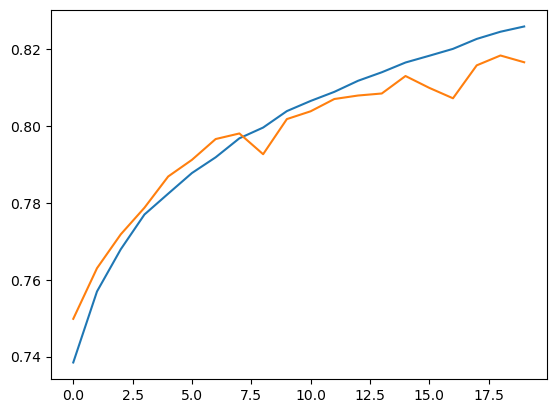

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

In [547]:
#test_case = "print('hello world')"
test_case = 'print "Hello World"'

In [548]:
test_case = tokenizer.texts_to_sequences([test_case])
test_case = pad_sequences(test_case, maxlen=MAX_SEQUENCE_LENGTH)


In [549]:
test_case

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0, 16,  7]])

In [550]:
model.predict(test_case)

1/1 [==============================] - 0s 26ms/step


array([[0.79749507]], dtype=float32)